In [8]:
import torch
from torch.nn import Sequential, Linear, Parameter, ReLU, ELU
import torch.nn.functional as F

import torch_geometric
from torch_geometric.nn import MessagePassing, GeneralConv, GCNConv
from torch_geometric.data import Data
from torch_geometric.utils import add_self_loops, segregate_self_loops, to_networkx
from typing import Any, Dict, List, Optional, Union
from torch import Tensor
from torch_geometric.nn.aggr import Aggregation
from torch_geometric.typing import Adj, OptTensor

%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt


In [9]:
from typing import Optional


from torch import Tensor


class GNNSConv(MessagePassing):
    def __init__(self, latent_dim: int, num_node_features: int, num_edge_features: int, alpha: float = 0.01) -> None:
        """
        Args:
            in_channels: число фичей в вершинах графа
            alpha: параметр для учета величины обновления X
        """
        super().__init__(aggr="add")
        self.alpha = alpha
        self.latent_dim = latent_dim

        self.mlp_in = Sequential(
            Linear(2 * latent_dim + num_edge_features, latent_dim),
            ELU(),
            Linear(latent_dim, latent_dim)
        )

        self.mlp_out = Sequential(
            Linear(2 * latent_dim + num_edge_features, latent_dim),
            ELU(),
            Linear(latent_dim, latent_dim)
        )

        self.mlp_psi = Sequential(
            Linear(latent_dim * 3 + num_edge_features, latent_dim),
            ELU(),
            Linear(latent_dim, latent_dim)
        )        

        self.reset_parameters()

    def reset_parameters(self):
        super().reset_parameters()

    def forward(self, X: Tensor, edge_index: Adj, node_attr: Tensor, edge_attr: Tensor) -> Tensor:
        """
        Args:
            X: Латентное представление данных в вершинах графа, [num_nodes, in_channels]    
            edge_index: Разреженная матрица смежности, [2, num_nodes]
            node_attr: Значения параметров в вершинах графа, [num_nodes, num_node_features]
            edge_attr: Значения атрибутов дуг графа, [num_edges, num_edge_features]
        """

        assert X.shape[1] == self.latent_dim, f'Размерность латентного вектора X должна совпадать с размерностью `latent_dim`, получено X.shape={X.shape}, latent_dim={self.latent_dim}'

        # print(f'forward pass, {X=}')

        # Формирование сообщения j -> i
        self.flow = 'source_to_target'
        phi_in = self.propagate(edge_index, x=X, edge_attr=edge_attr)
        # print(f'{phi_in=}')

        # Формирование сообщения i -> j
        self.flow = 'target_to_source'
        phi_out = self.propagate(edge_index, x=X, edge_attr=edge_attr)
        # print(f'{phi_out=}')

        # Объединение сообщений
        # print(f'{node_attr=}')
        inputs = torch.cat([X, node_attr, phi_in, phi_out], dim=-1)
        # print(f'{inputs=}')
        psi = self.mlp_psi(inputs)
        X = X + self.alpha * psi
        return X

    def message(self, x_i: Tensor, x_j: Tensor, edge_attr: OptTensor) -> Tensor:
        """
        Args:
            x_i: Target node features [num_edges, num_features]
            x_j: Source node features [num_edges, num_features]
            edge_attr: Source node features [num_edges, num_edge_features]
        """
        # print(">>> message ...")

        mlp = self.mlp_in if self.flow == "source_to_target" else self.mlp_out

        # print(f'{x_i=}')
        # print(f'{x_j=}')
        # print(f'{edge_attr=}')

        tmp = torch.cat([x_j, x_i, edge_attr], dim=-1) 
        
        # print(f'{tmp=}')
        out_message = mlp(tmp)
        # print(f'{out_message=}')

        return out_message


    def __repr__(self) -> str:
        return (f'{self.__class__.__name__}(aggr={self.aggr}, latent_dim={self.latent_dim})')


In [10]:
def visualize_graph(G, color):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False,
                     node_color=color, cmap="Set2")
    plt.show()

/home/ab/anaconda3/envs/nfsolver/lib/python3.11/site-packages/networkx/drawing/nx_pylab.py:433: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


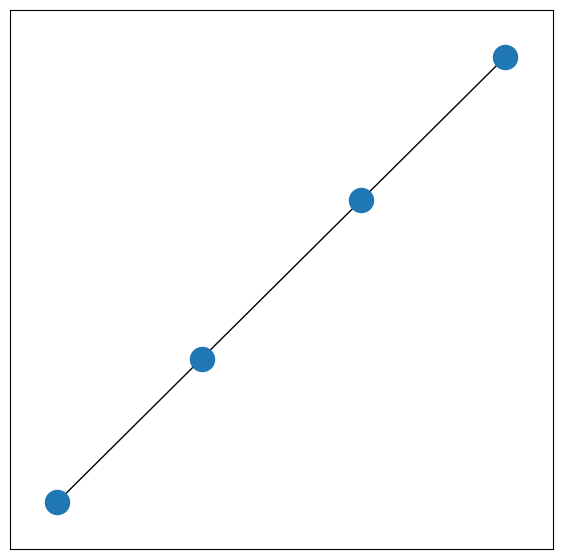

In [11]:
edge_index = torch.tensor([
  [0, 1, 2],
  [1, 2, 3]
], dtype=torch.long)

x = torch.tensor([[-1, 1], [-2, 2], [-3, 3], [-4, 4]], dtype=torch.float)
edge_attr = torch.tensor([
  [11, 12],
  [13, 14],
  [15, 16]
])

data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)

G = to_networkx(data, to_undirected=True)
visualize_graph(G, color=data.y);

In [12]:
class GNNProcessor(torch.nn.Module):
    """Обновляет латентные представления вершин графа за счет использования сверточной графовой нейронной сети.
    """
    def __init__(self, num_node_features: int, num_classes: int, num_edge_features: int, latent_dim: int = 6, num_convs: int = 3) -> None:
        """Инициализация

        Args:
            num_features (int): _description_
            num_classes (int): _description_
            num_edge_features (int): _description_
            latent_dim (int, optional): Размерность латентного пространства значений в вершинах графа (по умолчанию 10).
            num_convs (int, optional): Количество слоев свертки.
        """
        super().__init__()
        torch.manual_seed(1234)
        self.latent_dim = latent_dim

        self.convs = torch.nn.ModuleList([
            GNNSConv(self.latent_dim, num_node_features, num_edge_features) for _ in range(num_convs)
        ])

    def forward(self, data: Data):
        X = torch.zeros((data.num_nodes, self.latent_dim))
        edge_index, node_attr, edge_attr = data.edge_index, data.x, data.edge_attr

        for conv in self.convs:
            X = conv(X, edge_index, node_attr, edge_attr)
            X = F.elu(X)

        return X

In [15]:
model = GNNProcessor(data.num_features, 2, data.num_edge_features, latent_dim=6)
print(model)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
model.train()

for epoch in range(100):
  optimizer.zero_grad()
  out = model(data)
  

GNNProcessor(
  (convs): ModuleList(
    (0-2): 3 x GNNSConv(aggr=add, latent_dim=6)
  )
)


In [14]:
# model(data)
